Initialize a PiML Experiment

In [2]:
from piml import Experiment
exp = Experiment(highcode_only=True)

Load data, exclude demographic features and perform train-test split.

In [ ]:
import pandas as pd
data = pd.read_csv("https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true")
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=0, silent=True)

Fit a XGB2 model with 5000 iterations and learning rate 0.01

In [3]:
from piml.models import XGB2Classifier
exp.model_train(XGB2Classifier(n_estimators=5000, eta=0.01), name='XGB')

Evaluate train test performance against boosting iterations

In [5]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.metrics import roc_auc_score

train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

def score(model, iteration_range):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x, iteration_range=iteration_range)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x, iteration_range=iteration_range)[:, 1])
    tree_idx = np.logical_and(xgbinfo["Tree"] < iteration_range[1], xgbinfo["Tree"] >= iteration_range[0])
    n_leaves = np.sum(xgbinfo[tree_idx].loc[:, ["Feature"]].values == "Leaf")
    return {'n_leaves': n_leaves, 'n_iteration': iteration_range[1], 'train_auc': train_auc, 'test_auc': test_auc}

all_metrics = []
model = exp.get_model("XGB").estimator.estimator_
xgbinfo = model.get_booster().trees_to_dataframe()
for i in range(5000):
    metrics = score(model, (0, i + 1))
    all_metrics.append(metrics)
all_resluts = pd.DataFrame(all_metrics)

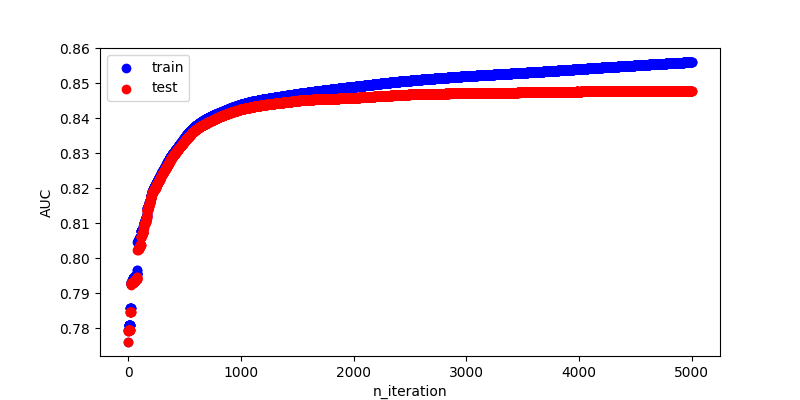

In [6]:
plt.figure(figsize=(8, 4))
plt.scatter(all_resluts["n_iteration"], all_resluts["train_auc"], color="blue", label="train")
plt.scatter(all_resluts["n_iteration"], all_resluts["test_auc"], color="red", label="test")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("n_iteration")
plt.show()